In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from scipy import signal
import scipy.stats as stats
import pickle
from netCDF4 import Dataset
import pprint

#load observed NSIDC Sea Ice Extent ('Extent') that has been regridded on sipn grid and divided into NSIDC regions   
filepath = '/home/disk/sipn/nicway/data/obs/NSIDC_0079/sipn_nc_yearly_agg/'  #observed sea ice extent data
##open_mfdataset(foo+'/*.nc') opens all nc files in specific directory
filename = xr.open_mfdataset(filepath+'/*.nc',concat_dim='time')

region_names = filename.region_names #list of region names
print(len(region_names))
print(region_names[8].values)
#get time (in datetime format)
time2 = filename.time
#print(time2.dt)
months = np.array(time2.dt.month)
days = np.array(time2.dt.day)
years = np.array(time2.dt.year)

#TIME = np.hstack((np.transpose(years),np.transpose(months),np.transpose(days)))
TIME = np.transpose(np.stack([years,months,days]))
print(TIME)
#np.transpose(years).shape
#SIC2 = xr.Dataset({filepath+filename})

15
Kara Sea
[[1989    1    1]
 [1989    1    2]
 [1989    1    3]
 ...
 [2018   12   29]
 [2018   12   30]
 [2018   12   31]]


0
'panArctic'
<xarray.DataArray 'Extent' (time: 10957)>
dask.array<shape=(10957,), dtype=float64, chunksize=(365,)>
Coordinates:
    nregions      int64 99
    region_names  object 'panArctic'
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2018-12-31
<xarray.DataArray 'Extent' (time: 10957)>
dask.array<shape=(10957,), dtype=float64, chunksize=(365,)>
Coordinates:
    nregions      int64 99
    region_names  object 'panArctic'
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2018-12-31


Text(0.5, 1.0, "Sea Ice Extent from NSIDC, 'panArctic', 1989-2018")

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


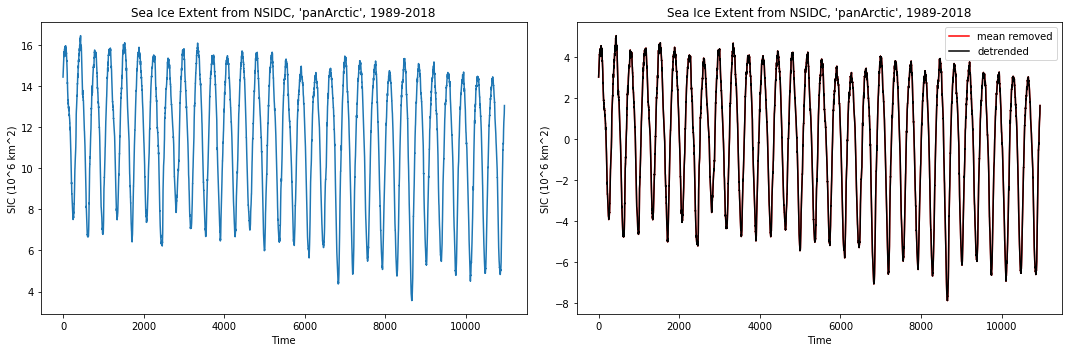

In [9]:
#read in SIC.  It is a time series for each region. Plot the time series, and the time series with its mean removed
test_region_ind = 0
test_region_name = np.array2string(region_names[test_region_ind].values)
#test_region_name = np.array2string(test_region_name)
test_region_name = test_region_name.replace(" ", "")
print(test_region_ind)
print(test_region_name)

SIC_load = filename.Extent
SIC = SIC_load[:,test_region_ind]
SIC_mean_rem = SIC - np.nanmean(SIC)
print(SIC)
print(SIC_mean_rem)
#Remove linear trend
#SIC_dt = signal.detrend(SIC_mean_rem)
SIC_dt = SIC_mean_rem
#plot
fig1, (ax1a, ax1b) = plt.subplots(1,2, figsize=(15,5),tight_layout = True)
ax1a.plot(SIC)
ax1a.set_xlabel('Time')
ax1a.set_ylabel('SIC (10^6 km^2)')
ax1a.set_title('Sea Ice Extent from NSIDC, {region_name}, 1989-2018'.format(region_name=test_region_name))
#
ax1b.plot(SIC_mean_rem,'r')
ax1b.plot(SIC_dt,'k')
ax1b.set_xlabel('Time')
ax1b.set_ylabel('SIC (10^6 km^2)')
ax1b.legend(['mean removed','detrended'])
ax1b.set_title('Sea Ice Extent from NSIDC, {region_name}, 1989-2018'.format(region_name=test_region_name))
#
#ax1c.plot(SIC_dt,'k')
#ax1c.set_xlabel('Time')
#ax1c.set_ylabel('SIC (10^6 km^2)')
#ax1c.set_title('Sea Ice Extent from NSIDC (detrended), 1978-2019')
#

10957
10957
10957


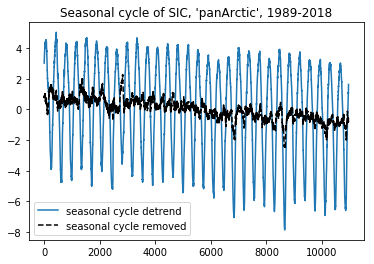

In [10]:
#Create running mean
nday = 1  #number of days for running mean
SIC_run_mean = np.convolve(SIC_dt,np.ones((nday,))/nday,mode='valid')
plt.plot(SIC_dt)
#plt.plot(SIC_run_mean,'r')
N = len(TIME) #number of time steps we have
TIME_rm = TIME[0:N-nday+1,:]
print(N)
print(len(TIME_rm))
print(len(SIC_run_mean))
##Remove seasonal cycle. For now we'll do +/- 2 days of the actual date
SIC_seasonal_cycle = np.array([])
N = len(TIME_rm)
for iseas in np.arange(0,N):
    idate = TIME_rm[iseas,:]
    ind_sel = np.where((TIME_rm[:,1] == idate[1]) & ((idate[2]-2 <= TIME_rm[:,2]) & (TIME_rm[:,2] <= idate[2]+2)))
    SIC_seasonal_cycle = np.append(SIC_seasonal_cycle,(SIC_run_mean[iseas,] - np.nanmean(SIC_run_mean[ind_sel,])))
    
plt.plot(SIC_seasonal_cycle,'k--')
plt.title('Seasonal cycle of SIC, {region_name}, 1989-2018'.format(region_name=test_region_name))
plt.legend(['seasonal cycle detrend','seasonal cycle removed'])

[-6.53644657e-04  1.19608099e+00]
0.00023809454802012326
-3.8827471899459027e-17


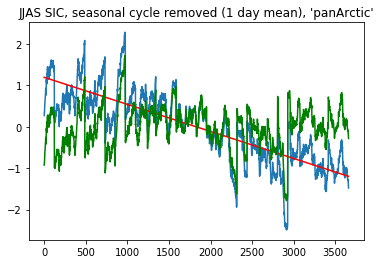

In [11]:
##Select only months we want
mon_sel = [6,7,8,9] #start w JJAS
mon_sel_ind = np.isin(months[0:len(TIME)-nday+1],mon_sel)
#print(mon_sel_ind)
#print(sum(mon_sel_ind)) make sure number of TRUEs makes sense

SIC_mon_sel = SIC_seasonal_cycle[np.where(mon_sel_ind == True)]
pf = np.polyfit(np.arange(0,len(SIC_mon_sel)),SIC_mon_sel,1)
print(pf)
line = pf[0]*np.arange(0,len(SIC_mon_sel)) + pf[1]
SIC_dt = SIC_mon_sel - line
#SIC_mon_dt = signal.detrend(SIC_mon_sel)
plt.plot(SIC_mon_sel)
plt.plot(line,'r')
plt.plot(SIC_dt,'g')
plt.title('JJAS SIC, seasonal cycle removed (1 day mean), {region_name}'.format(region_name=test_region_name))
print(np.nanmean(SIC_mon_sel))
print(np.nanmean(SIC_dt))

1.7236583781596848


Text(0.5, 0, 'SIC (10^6 km^2)')

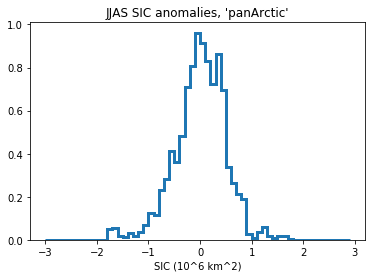

In [12]:

#histogram of JJAS SIC 
SIC_mon_sel = SIC_dt
fig = plt.figure()
print(np.amax(SIC_mon_sel))
plt.hist(SIC_mon_sel,bins=np.arange(-3,3,0.1),histtype=u'step', density=True,linewidth=3)
#plt.plot(SIC_pde)
#sns.distplot(SIC_mon_sel,hist=False,kde=True,kde_kws={'linewidth':4})
plt.title('JJAS SIC anomalies, {region_name}'.format(region_name=test_region_name))
plt.xlabel('SIC (10^6 km^2)')

(10953,)
[[1989    5   30]
 [1989    5   31]
 [1989    6    1]
 ...
 [2018    9   26]
 [2018    9   27]
 [2018    9   28]]
[1, 5, 25, 50, 75, 95, 99]
[-0.32218322 -0.19139422 -0.06538136  0.00594592  0.07334021  0.17221196
  0.24611098]
-0.00011096565180361948 0.11304264173000769 -0.40207429687528395 1.0918971409260143


Text(0.5, 0, 'change in SIC (10^6 km^2)')

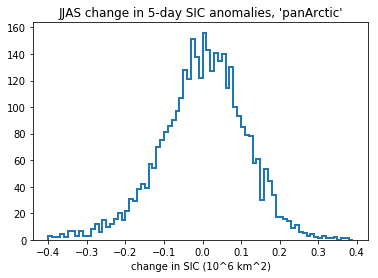

In [49]:
##now look at change in SIC -/+ 2 days
SIC_delta = np.array([])
pm_days = 2
nodays = 2*pm_days + 1
seas_str = 'JJAS'

for idelta in np.arange(pm_days,len(SIC_seasonal_cycle)-pm_days):
    SIC_idelta = SIC_seasonal_cycle[idelta+pm_days] - SIC_seasonal_cycle[idelta-pm_days]
    SIC_delta = np.append(SIC_delta,SIC_idelta)

    
print(SIC_delta.shape)
SIC_delta_sel = SIC_delta[np.where(mon_sel_ind[pm_days:len(mon_sel_ind)-pm_days] == True)]
TIME_sel = TIME_rm[np.where(mon_sel_ind[pm_days:len(mon_sel_ind)-pm_days] == True)]
print(TIME_sel)
pctile_select = [1,5,25,50,75,95,99] #select 1st/99th, 5th/95th, 25/75th, and 50th pctiles (median)
pctiles = np.percentile(SIC_delta_sel,pctile_select) #median
skew = stats.skew(SIC_delta_sel) #skewness
sdev = np.std(SIC_delta_sel) #standard deviation
mean = np.nanmean(SIC_delta_sel) #mean
kurt = stats.kurtosis(SIC_delta_sel) #kurtosis
print(pctile_select)
print(pctiles)
print(mean,sdev,skew,kurt)
plt.hist(SIC_delta_sel,bins=np.arange(-0.4,0.4,0.01),histtype=u'step',density=False,linewidth=2)
plt.title('JJAS change in 5-day SIC anomalies, {region_names}'.format(region_names=test_region_name))
plt.xlabel('change in SIC (10^6 km^2)')

In [65]:
#Save our relevant metrics with picle
pct1 = pctiles[0]
pct5 = pctiles[1]
pct25 = pctiles[2]
pct50 = pctiles[3]
pct75 = pctiles[4]
pct95 = pctiles[5]
pct99 = pctiles[6]
print(test_region_name)
print(pctiles.dtype)
print(SIC_delta_sel.dtype)
#pctile_ds = pctiles.to_dataset(name='pctiles')

'panArctic'
float64
float64


In [69]:
SIE_delta = SIC_delta_sel
SIE_delta = np.array(SIE_delta)
print(SIE_delta)
#print(SIE_delta.dtype)
fname_save = '/home/disk/sipn/mcmcgraw/python/data_VRILEs/{region}_SIE_delta_{nodays}days_NSIDC_{seas}.txt'.format(region=test_region_name,nodays=nodays,seas=seas_str)
np.savetxt(fname_save,SIE_delta,fmt='%.9f')
#pfile = open(fname_save,'wb')
#pfile = pickle.dumps(SIE_delta)
#print('PICKLE: ',pfile)
#pfile.close()


[ 0.01898638  0.0465757   0.08223525 ... -0.15350894 -0.36903785
 -0.33149938]


In [70]:
cont2 = np.genfromtxt(fname_save,unpack='True')
print(cont2)

[ 0.01898638  0.0465757   0.08223525 ... -0.15350894 -0.36903784
 -0.33149938]


print(cont2 - SIE_delta)

In [71]:
print(cont2 - SIC_delta_sel)

[ 3.90258964e-10  2.97011110e-10 -4.43358558e-10 ...  2.94053282e-10
  9.86058457e-11 -3.71602416e-10]
